<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/BlackPlague-SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import emcee
import pystan
import time
import pytwalk as twalk

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pip install emcee

In [4]:

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

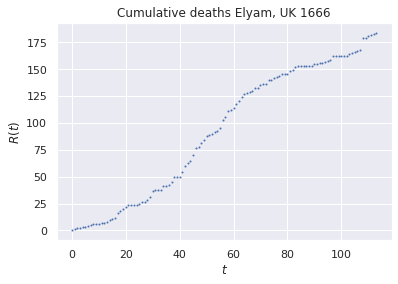

In [5]:

''' Second black plague outbreak in Eyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261 #Total population   

def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )



plt.scatter( ts,y, s=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'$R(t)$' )
plt.title('Cumulative deaths Elyam, UK 1666')
plt.savefig('plotcumdeaths.png', dpi=500)
plt.show()



In [110]:

def logprior( Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
         b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
         return a+b
    else:
         return -np.inf
    
    
def logL(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    n=len(y)
    X0=np.array( [N-I0, I0, 0] )
    Xt = odeint( SIR, X0, ts, args=(alpha,beta,I0,))  
    It= Xt[:,1]
    It[It<0]=0
    Rt=Xt[:,2]
    Rt[Rt>261]=261
    ll=0
    ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
    ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
    return ll
    

def lpost(Theta): #energy function
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         return -logprior(Theta)-logL(Theta) 
    else:
         return np.inf
  

def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb:array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])
    mask = np.zeros( theta.shape, dtype=bool )
    mask[pars] = True
    temp=np.zeros(theta.shape)
    for i in range( m ):
        for j in range( m ):
            temp[mask]=np.array( [xx[i][j], yy[i][j]] )
            temp[~mask]= theta[~mask]
            #Z[i][j] = f( temp , args)
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()

def pSurface(xx,yy, Z):
    fig = plt.figure()
    ax = plt.axes( projection='3d' )
    ax.plot_surface( xx, yy, Z, cmap='Spectral')
    # ax.contour3D(xx, yy, Z, 30, cmap='binary')
    ax.set_xlabel( r'$\theta_1$' )
    ax.set_ylabel( r'$\theta_2$' )
    ax.set_zlabel( r'$Posterior Surface' )
    ax.view_init( 60, 35 )
    fig

def SolveSIR(theta):
  #Solve SIR for given parameter theta
  alpha=theta[0]
  beta=theta[1]
  I0=theta[2]
  X0=np.array( [N-I0, I0, 0] )
  temp=odeint( SIR, X0, ts, args=(alpha,beta,I0,))
  return temp






In [ ]:
#Critical points 
from scipy import optimize

a=scipy.stats.uniform.rvs( 0.085, 0.12-0.085, 1  )
b=scipy.stats.uniform.rvs( 0.0004, 0.00075-0.0004, 1  )

xopt=optimize.minimize( lpost ,  np.array([a[0],b[0],5 ])  ,method='bfgs', tol=1e-5)
xopt['x']


array([8.89918795e-02, 7.03413260e-04, 5.00000000e+00])

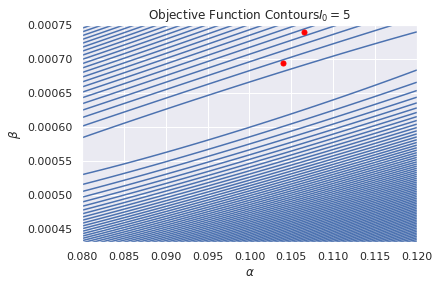

In [ ]:
#Maximum points and contour function

xx,yy,Z= fpoints(f= lpost,args=1, theta= np.array([ 0.09 , 0.0007 , 5 ]) ,
                  pars= np.array([ 0,1]),
                  lb=np.array([ 0.080, 0.00043 ])  , upb= np.array([ .120 , 0.00075  ])  , m=100 )

#xopt1=np.array([1.03235218e-01, 6.54904342e-04, 4.30228503e+00])
xopt1=np.array([1.03974221e-01, 6.94544193e-04, 5.00000000e+00])
xopt2=np.array([1.06568129e-01, 7.38785972e-04, 5.00000000e+00])

plt.plot( xopt1[0],xopt1[1] ,'.' , markersize=10 , color='red')
plt.plot( xopt2[0],xopt2[1] , '.' , markersize=10 , color='red')
plt.contour( xx, yy, Z, 100, colors='b' )
plt.xlabel( r'$\alpha$')
plt.ylabel( r'$\beta$' )
plt.title( r'Objective Function Contours'+r'$I_0=5$' )
plt.show()

In [46]:
#----------------------- t-walk

def p0(): #prior function for the t walk
    a=scipy.stats.uniform.rvs(0, 1 , 1)
    b= scipy.stats.uniform.rvs(0, 1 , 1)
    c=scipy.stats.uniform.rvs(0,10, 1)
   
    return np.array([a[0],b[0],c[0]])


def supp(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>0 and I0<=20 and alpha<1 and beta<1  ):
         return True
    else:
        return False



In [68]:

T=50000 #number of iterations
#x0= np.array([1.11528561e-01, 7.42622491e-04, 5.00000000e+00])
#xp0=np.array([1.03351566e-01, 6.55532405e-04, 4.29146012e+00])


x0=p0()
xp0=p0()

tchain = twalk.pytwalk( n=3, U=lpost, Supp=supp )
tchain.Run( T=T , x0= np.array([0.01, 0.000692, 7]) , xp0= np.array([0.05, 0.000652, 9.5]))




pytwalk: Running the twalk with 50000 iterations .  Fri, 18 Sep 2020, 23:57:08.
       Finish in approx. 1 min and 49 sec.


/content/pytwalk.py:304: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)


pytwalk: finished, Fri, 18 Sep 2020, 23:57:38.


1

Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[0.3971976 0.1710356 0.        0.       ]
Global acceptance rate: 0.27902
AutoMaxlag: maxlag= 152.
Integrated Autocorrelation Time:    56.1, IAT/n:    18.7
AutoMaxlag: maxlag= 152.


matrix([[56.13596163]])

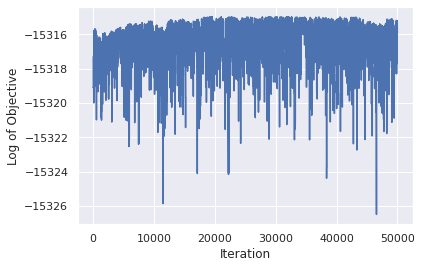

In [53]:

tchain.Ana()
tchain.IAT()


In [69]:
bi=int(0.20*T)
toutput=tchain.Output[:, 0:3 ]
print(toutput.shape)


(50001, 3)


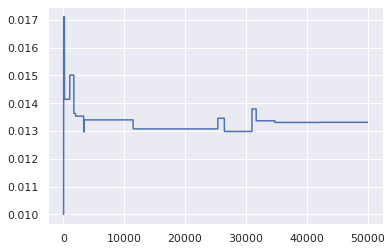

In [70]:
plt.plot(toutput[:,0])

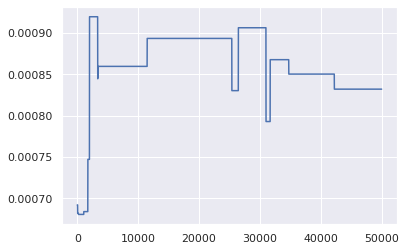

In [71]:
plt.plot(toutput[:,1])

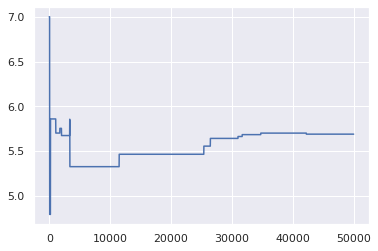

In [72]:
plt.plot(toutput[:,2])

In [73]:
alpha=toutput[bi:,0]
beta=toutput[bi:,1]
I0=toutput[bi:,2]

rt={'alpha': alpha, 'beta':beta, 'I0':I0}
rt=pd.DataFrame(rt)

In [74]:
pd.DataFrame.describe(rt)

,alpha,beta,I0
count,40001.000000,40001.000000,40001.000000
mean,0.013213,0.000868,5.590350
std,0.000163,0.000029,0.115449
min,0.012984,0.000793,5.326444
25%,0.013078,0.000850,5.464888
50%,0.013309,0.000868,5.641879
75%,0.013314,0.000893,5.689418
max,0.013794,0.000906,5.701017


In [75]:
pd.DataFrame.median(rt)

alpha    0.013309
beta     0.000868
I0       5.641879
dtype: float64

In [76]:
pd.DataFrame.quantile(rt, (0.025, 0.975))

,alpha,beta,I0
0.025,0.012984,0.000830,5.326444
0.975,0.013459,0.000906,5.701017


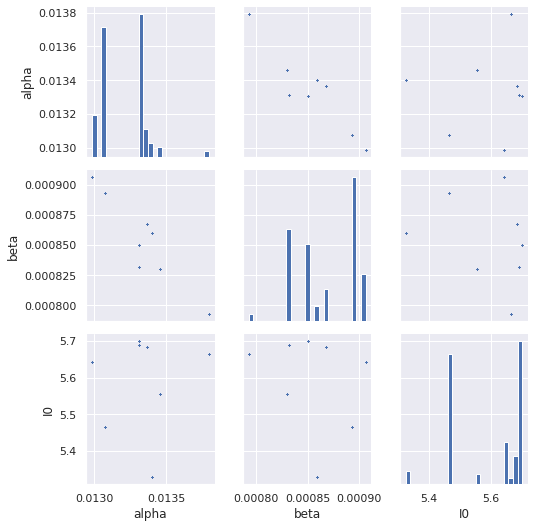

In [77]:
sns.pairplot(rt, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=25) )
plt.tight_layout()
plt.savefig('twpairplot.png', dpi=500)

In [78]:

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs
        
        



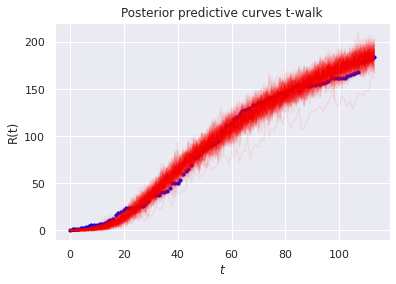

In [79]:

  
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs( toutput[:,0] , toutput[:,1] , toutput[:,2]   , tup=114, sample_size=300)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =150, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.07 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves t-walk' )
plt.savefig( 'twalkRtBlackPlague.pdf', dpi=500  )
plt.show()



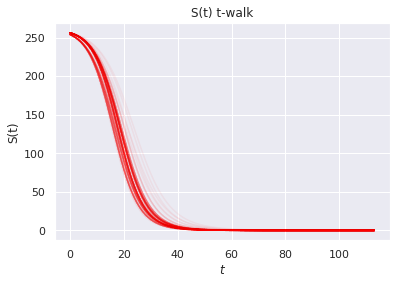

In [80]:
for i in range( len(obs_samples )  ):
    plt.plot(SSts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) t-walk' )
plt.savefig( 'twSt.pdf', dpi=500  )
plt.show()



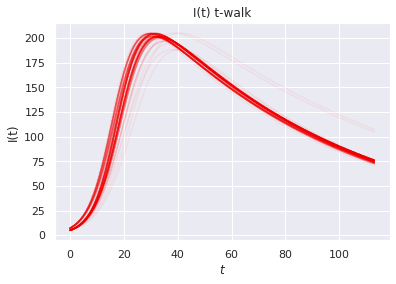

In [81]:
for i in range( len(obs_samples )  ):
    plt.plot(IIts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) t-walk' )
plt.savefig( 'twIt.pdf', dpi=500  )
plt.show()


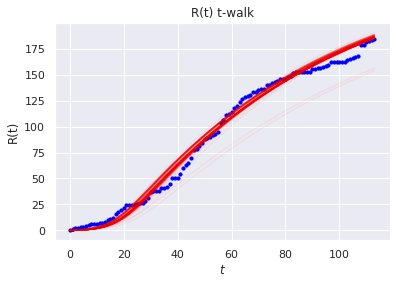

In [82]:
for i in range( len(obs_samples )  ):
    plt.plot(RRts[i], color='red' , alpha=0.05 )
plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) t-walk' )
plt.savefig( 'twRt.pdf', dpi=500  )
plt.show()


In [149]:
# ------------------------------- emcee


def post_emcee(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=13 and alpha<1 and beta<1  ):
         return logprior(Theta)+logL(Theta) 
    else:
         return -np.inf
    

def p0_emcee(nwalkers=1):
    p0=np.zeros([nwalkers,3])
    a=scipy.stats.uniform.rvs(0, 0.12, nwalkers)
    b= scipy.stats.uniform.rvs(0,0.0008  , nwalkers)
    c=scipy.stats.uniform.rvs(0,13, nwalkers)
    p0[:,0]=a
    p0[:,1]=b
    p0[:,2]=c
    return p0


In [151]:

import os

os.environ["OMP_NUM_THREADS"] = "8"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [152]:
nwalkers = 25
T=250000

p0=p0_emcee(nwalkers)
ndim=p0.shape[1]


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_emcee, pool=pool)
    sampler.run_mcmc(p0, T, progress=True)
    

  0%|          | 0/250000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 250000/250000 [1:47:56<00:00, 38.60it/s]


In [153]:
bi=int(0.33*T)
samples = sampler.get_chain(flat=True)
emcee_chains = sampler.get_chain(discard=bi)
 


In [154]:
sampler.get_autocorr_time()

array([107.91450489, 120.07871544, 129.31523326])

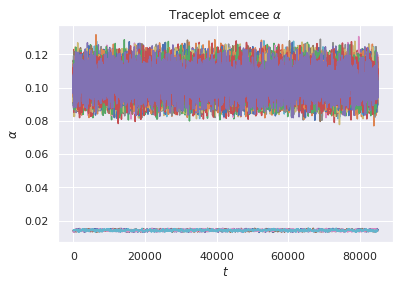

In [157]:
for i in range(nwalkers):
  plt.plot(emcee_chains[bi:,i,0 ])

#alpha chains
plt.xlabel( r'$t$' )
plt.ylabel( r'$\alpha$' )
plt.title( 'Traceplot emcee '+r'$\alpha$' )
plt.savefig( 'mctracealphasir.pdf', dpi=500  )
plt.show()



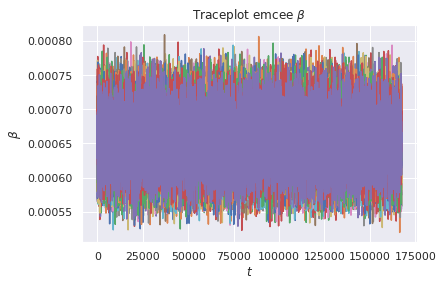

In [158]:
for i in range(nwalkers):
  plt.plot(emcee_chains[:,i,1 ])

#beta chains
plt.xlabel( r'$t$' )
plt.ylabel( r'$\beta$' )
plt.title( 'Traceplot emcee '+r'$\beta$' )
plt.savefig( 'mctracebetasir.pdf', dpi=500  )
plt.show()



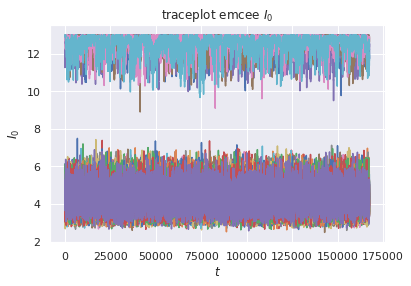

In [159]:
for i in range(nwalkers):
  plt.plot(emcee_chains[:,i,2 ])


plt.xlabel( r'$t$' )
plt.ylabel( r'$I_0$' )
plt.title( 'traceplot emcee '+r'$I_0$' )
plt.savefig( 'mctraceiosir.pdf', dpi=500  )
plt.show()



In [160]:
alpha=samples[bi:,0]
beta=samples[bi:,1]
I0=samples[bi:,2]

In [161]:
d = {'alpha': samples[bi:,0], 'beta': samples[bi:,1], 'I0': samples[bi:,2] }
emceeresults= pd.DataFrame(data=d)


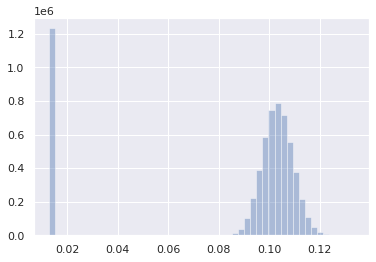

In [162]:
sns.distplot(  alpha, kde=False    )

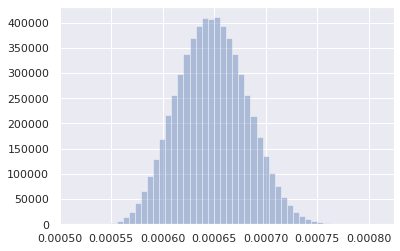

In [163]:
sns.distplot(  beta, kde=False    )

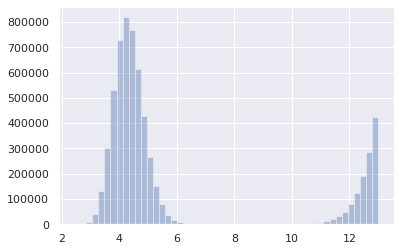

In [164]:
sns.distplot(  I0, kde=False    )

In [165]:
talpha=alpha
tbeta=beta
tI0=I0
tmc={ 'alpha':talpha, 'beta':tbeta, 'I0':tI0  }
tmc=pd.DataFrame(tmc)

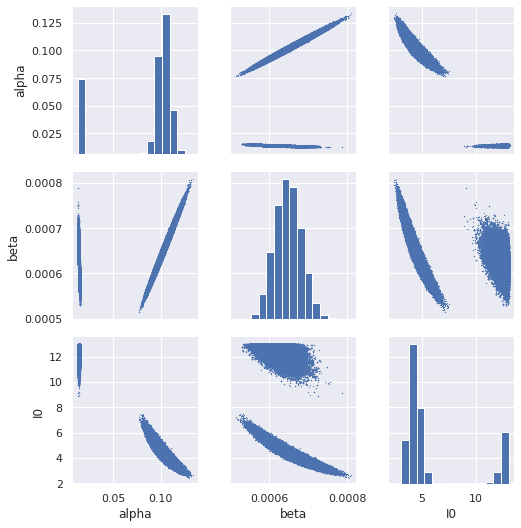

In [166]:
sns.pairplot(tmc, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=15) )
plt.tight_layout()
plt.savefig('mcpairplot.png', dpi=500)

In [144]:
### predictive observations

def predobs( alpha, beta, I0s, tup=136  ,sample_size=1000 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs

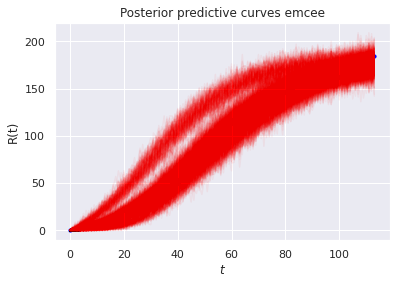

In [167]:
#### Predictive distribution


mm=1000
SSts, IIts, RRts,  obspred=predobs( talpha , tbeta , tI0   , tup=114, sample_size=mm)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =mm, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves emcee' )
plt.savefig( 'mcRtBlackPlague.pdf', dpi=500  )
plt.show()


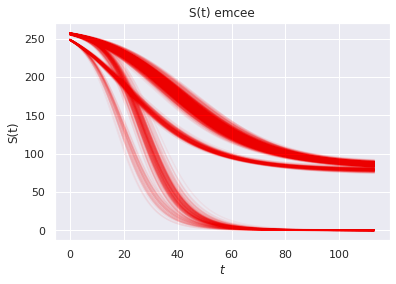

In [168]:
for i in range( len(obs_samples )  ):
    plt.plot(SSts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) emcee' )
plt.savefig( 'mcSt.pdf', dpi=500  )
plt.show()

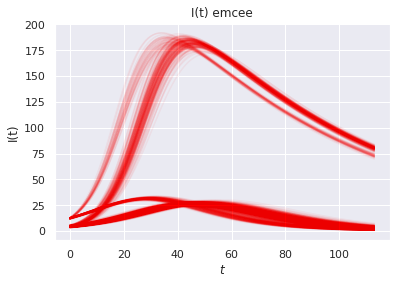

In [169]:
for i in range( len(obs_samples )  ):
    plt.plot(IIts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) emcee' )
plt.savefig( 'mcIt.pdf', dpi=500  )
plt.show()

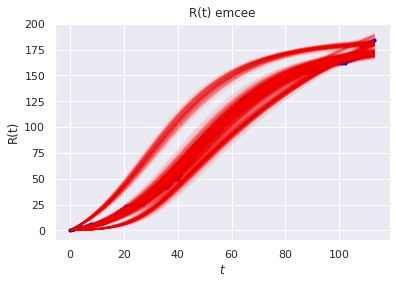

In [170]:
for i in range( len(obs_samples )  ):
    plt.plot(RRts[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) emcee' )
plt.savefig( 'mcRt.pdf', dpi=500  )
plt.show()

In [171]:
pd.DataFrame.describe(tmc)

,alpha,beta,I0
count,6.167500e+06,6.167500e+06,6.167500e+06
mean,8.549683e-02,6.478797e-04,5.976387e+00
std,3.609471e-02,3.384106e-05,3.314389e+00
min,1.286361e-02,5.138073e-04,2.429419e+00
25%,9.427586e-02,6.239874e-04,4.066442e+00
50%,1.013727e-01,6.474208e-04,4.472157e+00
75%,1.062035e-01,6.709985e-04,5.165025e+00
max,1.335167e-01,8.092366e-04,1.300000e+01


In [172]:
pd.DataFrame.median(tmc)

alpha    0.101373
beta     0.000647
I0       4.472157
dtype: float64

In [173]:
pd.DataFrame.quantile(tmc, (0.025, 0.975))

,alpha,beta,I0
0.025,0.013727,0.000584,3.458072
0.975,0.114657,0.000715,12.931354


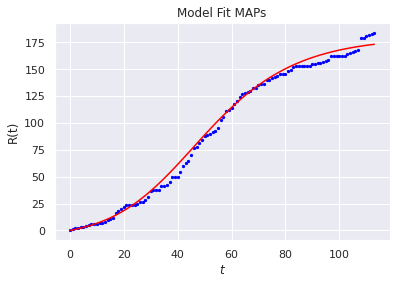

In [174]:
temp=SolveSIR( np.array([0.1013, 0.000647,4.72])   )

plt.plot(temp[:,2], color='red' )
plt.scatter(ts,y, s=5, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Model Fit MAPs' )
plt.savefig( 'map1.pdf', dpi=500  )
plt.show()